# Data analysis of project for CS-A1155 - Databases for Data Science

### Group 14: Benjamin Herman, Quoc Quang Ngo, Thinh Nguyen

In [47]:
# import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import sqlalchemy
from datetime import date


def conditional_commit():
    """Commit if major version number is greater than 1"""
    if int(sqlalchemy.__version__.split('.')[0]) > 1:
        psql_conn.commit()


in_script = False
cred_file = 'credentials.json'
# cred_file = 'credentials.json'
# use 'credentials.json' to connect to the remote database

# Load a dictionary of credentials
with open(cred_file) as fp:
    creds = json.load(fp)

db_url = 'postgresql+psycopg2://' + \
    '{user}:{password}@{host}:{port}/{database}'. \
    format(**creds)

engine = create_engine(db_url)


### Data analysis

In this part, we further examined the analyses done in question 4,5 and 6 of project part 3 by visualizing the output data.

In [48]:
## Add a new column 'agrGroup' to patient df 
with engine.connect() as psql_conn:
    patients_df = pd.read_sql_table('patients', psql_conn)
    print(patients_df['dateofbirth'].dtypes)
    today = date.today()
    patients_df['age'] = patients_df['dateofbirth'].apply(
        lambda x: today.year - x.year - 
        ((today.month, today.day) < (x.month, x.day)))
    
    bins= [0,10,20,40,60,200]
    labels = ['0-10','10-20','20-40','40-60','60+']
    patients_df['ageGroup'] = pd.cut(patients_df['age'], bins=bins,
                                     labels=labels, right=False)
    patients_df = patients_df.drop(columns=['age'])
    print(patients_df)
    

datetime64[ns]
            ssno                   name dateofbirth gender ageGroup
0    841229-112N       Rodolfo O'Reilly  1984-12-29      M    20-40
1    780214-1893  Prof. Erling Morar MD  1978-02-14      F    40-60
2    950303-191X  Dr. Simeon Keeling II  1995-03-03      M    20-40
3    730218-253D            Dereck Beer  1973-02-18      M    40-60
4    971214-2818   Prof. Brice Metz PhD  1997-12-14      M    20-40
..           ...                    ...         ...    ...      ...
145  881210-971J        Brain Greenholt  1988-12-10      M    20-40
146  110614-978B      Ms. Hanna Corkery  2011-06-14      F    10-20
147  830908-9826               Ana Ward  1983-09-08      F    20-40
148  080305-985A             Ricky Kuhn  2008-03-05      M    10-20
149  011119-9865          Ahmad Kovacek  2001-11-19      M    20-40

[150 rows x 5 columns]


In [49]:
# Add a new column 'vaccinationStatus'. 
# The value '0' represents 'not vaccinated', '1' for 'vaccinated once', and '2' for 'fully-vaccinated'.
with engine.connect() as psql_conn:
    statement = '''
    -- the number of vaccines a patient has had so far
    SELECT DISTINCT p.ssno As patientSsNo, COUNT(*) AS vaccinationstatus
    FROM patients p
    JOIN vaccinepatients vp ON p.ssno = vp.patientssno
    GROUP BY p.ssno;
        '''
    result = psql_conn.execute(text(statement))
    out = result.fetchall()
    column_names = list(result.keys())
    df = pd.DataFrame.from_records(out, columns=column_names)
    output_string = df.to_string(index=False)
    
    merged_df = pd.merge(patients_df, df, left_on='ssno',
                         right_on='patientssno',
                         how='left').drop('patientssno', axis=1)
    merged_df['vaccinationstatus'] = merged_df['vaccinationstatus'] \
        .fillna(0).astype('int64')
    merged_df.rename({'vaccinationstatus': 'vaccinationStatus'},
                     axis=1, inplace=True)
    print(merged_df)
    

            ssno                   name dateofbirth gender ageGroup  \
0    841229-112N       Rodolfo O'Reilly  1984-12-29      M    20-40   
1    780214-1893  Prof. Erling Morar MD  1978-02-14      F    40-60   
2    950303-191X  Dr. Simeon Keeling II  1995-03-03      M    20-40   
3    730218-253D            Dereck Beer  1973-02-18      M    40-60   
4    971214-2818   Prof. Brice Metz PhD  1997-12-14      M    20-40   
..           ...                    ...         ...    ...      ...   
145  881210-971J        Brain Greenholt  1988-12-10      M    20-40   
146  110614-978B      Ms. Hanna Corkery  2011-06-14      F    10-20   
147  830908-9826               Ana Ward  1983-09-08      F    20-40   
148  080305-985A             Ricky Kuhn  2008-03-05      M    10-20   
149  011119-9865          Ahmad Kovacek  2001-11-19      M    20-40   

     vaccinationStatus  
0                    2  
1                    1  
2                    1  
3                    1  
4                    1

In [50]:
# A spreadsheet-style pivot table as a dataFrame is created and shows the percentage of patients 
# who have received zero, one, or two doses of vaccines by age group.

with engine.connect() as psql_conn:
    pivot_df = pd.pivot_table(merged_df, index='vaccinationStatus', 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')
    
    pivot_df['0-10'] = round((pivot_df['0-10']/pivot_df['0-10'].sum())*100, 2). \
                       fillna(0).astype(str) + '%'
    pivot_df['10-20'] = round((pivot_df['10-20']/pivot_df['10-20'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    pivot_df['20-40'] = round((pivot_df['20-40']/pivot_df['20-40'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    pivot_df['40-60'] = round((pivot_df['40-60']/pivot_df['40-60'].sum())*100, 2). \
                        fillna(0).astype(str) + '%'
    pivot_df['60+'] = round((pivot_df['60+']/pivot_df['60+'].sum())*100, 2). \
                      fillna(0).astype(str) + '%'
    print(pivot_df)

ageGroup             0-10   10-20   20-40  40-60   60+
vaccinationStatus                                     
0                  57.14%  35.14%  32.69%  52.5%  0.0%
1                  33.33%  56.76%  55.77%  45.0%  0.0%
2                   9.52%   8.11%  11.54%   2.5%  0.0%


#### Question 1: How does the vaccination progress look like for each age group compared to its total age group population?

ageGroup            0-10  10-20  20-40  40-60  60+
vaccinationStatus                                 
0                  57.14  35.14  32.69   52.5  0.0
1                  33.33  56.76  55.77   45.0  0.0
2                   9.52   8.11  11.54    2.5  0.0


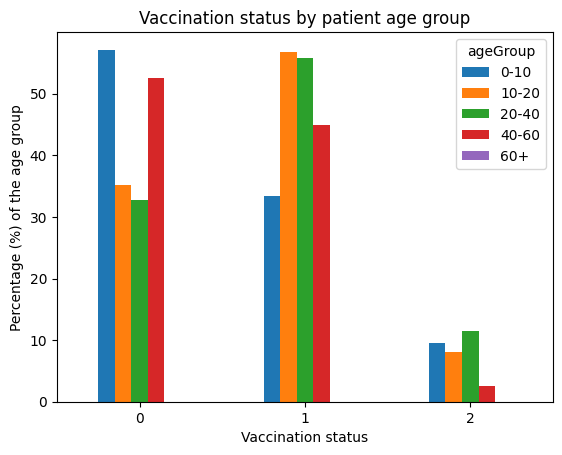

In [51]:
with engine.connect() as psql_conn:
    df = pd.pivot_table(merged_df, index='vaccinationStatus', 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')
    
    df['0-10'] = round((df['0-10']/df['0-10'].sum())*100, 2). \
                       fillna(0)
    df['10-20'] = round((df['10-20']/df['10-20'].sum())*100, 2). \
                        fillna(0)
    df['20-40'] = round((df['20-40']/df['20-40'].sum())*100, 2). \
                        fillna(0)
    df['40-60'] = round((df['40-60']/df['40-60'].sum())*100, 2). \
                        fillna(0)
    df['60+'] = round((df['60+']/df['60+'].sum())*100, 2). \
                      fillna(0)
    
    print(df)
    
    df.plot(kind='bar')
    plt.title('Vaccination status by patient age group')
    plt.xlabel('Vaccination status')
    plt.xticks(rotation = 0)
    plt.ylabel('Percentage (%) of the age group')

The plot above illustrates the vaccination status in percentage of each patient age group compared to its group population. 

It is clear that there were no patients over 60 years old and the vaccination progress was not equal among age groups. Most children between 0 and 10 years old were either not vaccinated or vaccinated once with over 50% and one third of the total group size respectively. Similarly, slightly over half of the age group 40-60 did not receive any Corona vaccination, but the percentage of those who got vaccinated once was higher than the previously mentioned group by almost 12%. Groups of 10-20 youngsters and 20-40 people both show a higher percentage in the vaccinated once status with over 50%, followed by non-vaccinated status with approximately 33-35% of the total group population. In addition, the plot shows that the number of patients in each age group getting vaccinated twice was very small, compared to the total age group size. 

#### Question 2: How does the vaccination progress look like for each age group compared to the total sample population?

ageGroup           0-10  10-20  20-40  40-60  60+
vaccinationStatus                                
0                  8.00   8.67  11.33  14.00  0.0
1                  4.67  14.00  19.33  12.00  0.0
2                  1.33   2.00   4.00   0.67  0.0


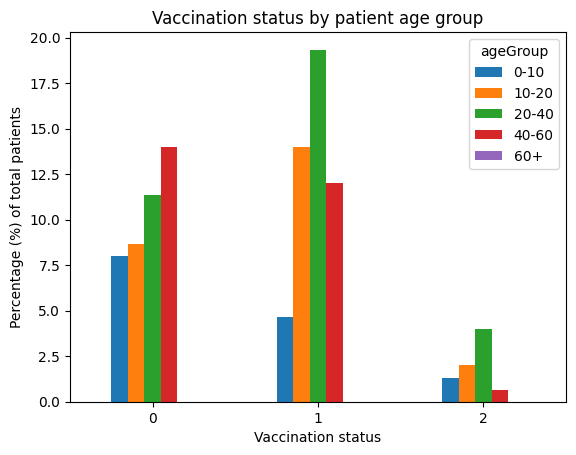

In [52]:
with engine.connect() as psql_conn:
    df2 = pd.pivot_table(merged_df, index='vaccinationStatus', 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')

    df2['0-10'] = round((df2['0-10']/len(merged_df))*100, 2). \
                       fillna(0)
    df2['10-20'] = round((df2['10-20']/len(merged_df))*100, 2). \
                        fillna(0)
    df2['20-40'] = round((df2['20-40']/len(merged_df))*100, 2). \
                        fillna(0)
    df2['40-60'] = round((df2['40-60']/len(merged_df))*100, 2). \
                        fillna(0)
    df2['60+'] = round((df2['60+']/len(merged_df))*100, 2). \
                      fillna(0)
    
    print(df2)
    df2.plot(kind='bar')
    plt.title('Vaccination status by patient age group')
    plt.xlabel('Vaccination status')
    plt.xticks(rotation = 0)
    plt.ylabel('Percentage (%) of total patients')

The plot above presents the vaccination status in percentage of each patient age group compared to the total population. According to this data visualization, there were no patients over 60 years old and the vaccination progress was not equal among age groups. 

In general, the majority of the population were either not vaccinated or vaccinated once with 92% in total. The highest percentage is found in the age group 20-40 with the vaccinated once status, followed by the age group 40-60 with the vaccinated once status and the age group 10-20 who did not get vaccinated. It can be also noted that the number of fully vaccinated people accounts for a very small portion in each age group. The highest portion can be seen in the age group 20-40 with 4% of the whole population. 

#### Question 3: How does the vaccination progress look like for each gender and each age group?

ageGroup                  0-10  10-20  20-40  40-60  60+
gender vaccinationStatus                                
F      0                     7      7      5     10    0
       1                     3     17     11      9    0
       2                     2      0      1      1    0
M      0                     5      6     12     11    0
       1                     4      4     18      9    0
       2                     0      3      5      0    0


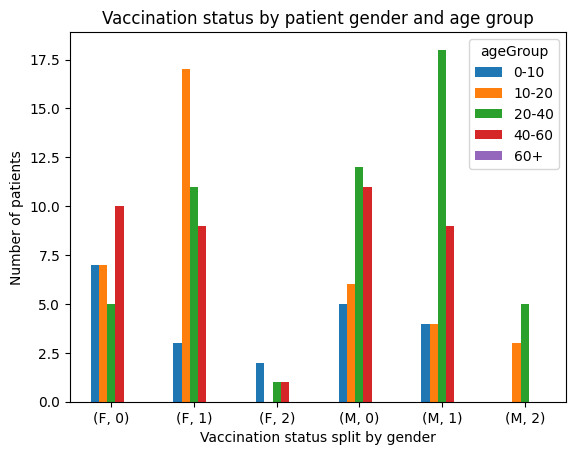

In [53]:
with engine.connect() as psql_conn:
    df3 = pd.pivot_table(merged_df, index=['gender', 'vaccinationStatus'], 
                         values='ssno', 
                         columns='ageGroup',
                         aggfunc='count')
    print(df3)
    
    df3.plot(kind='bar')
    plt.title('Vaccination status by patient gender and age group')
    plt.xlabel('Vaccination status split by gender')
    plt.xticks(rotation = 0)
    plt.ylabel('Number of patients')

The plot above shows the vaccination status of each age group and patient gender. It is evident from this visualization that the vaccination progress varies among age groups and genders, even though both genders constitute an almost equal portion of the population. 17 female patients got vaccinated once and aged between 10 and 20, making this segment the largest in the female group followed by those with the same vaccination status but aged 20-40. In their counterpart group, the biggest group includes male patients between 20 and 40 with the vaccinated once status, followed by those in the same age group by not getting vaccinated yet. 